## Colab 셋팅

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# # runtime 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install pandas==1.3.4
!pip install category_encoders
!pip install optuna

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


## 라이브러리

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from category_encoders import BinaryEncoder
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [26]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['font.size'] = 13

In [27]:
# %matplotlib inline

# # 사용자 운영체제 확인
# import os
# os.name

# # 운영체제별 한글 폰트 설정
# if os.name == 'posix': # Mac 환경 폰트 설정
#     plt.rc('font', family='AppleGothic')
# elif os.name == 'nt': # Windows 환경 폰트 설정
#     plt.rc('font', family='Malgun Gothic')
# plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# # 글씨 선명하게 출력하는 설정
# %config InlineBackend.figure_format = 'retina'

## 데이터 읽기

In [28]:
path_train = '/content/drive/MyDrive/235867_물류 유통량 예측 경진대회/train_df.csv'
path_test = '/content/drive/MyDrive/235867_물류 유통량 예측 경진대회/test_df.csv'

X_train = pd.read_csv(path_train, encoding='cp949')
X_test = pd.read_csv(path_test, encoding='cp949')

## feature engineering

In [29]:
X_train = X_train.astype({'SEND_SPG_INNB': 'str'})
X_train = X_train.astype({'REC_SPG_INNB': 'str'})
# X_train['SEND_SPG_INNB'] = X_train['SEND_SPG_INNB'].apply(lambda x: x[:-6])
# X_train['REC_SPG_INNB'] = X_train['REC_SPG_INNB'].apply(lambda x: x[:-6])

X_test = X_test.astype({'SEND_SPG_INNB': 'str'})
X_test = X_test.astype({'REC_SPG_INNB': 'str'})
# X_test['SEND_SPG_INNB'] = X_test['SEND_SPG_INNB'].apply(lambda x: x[:-6])
# X_test['REC_SPG_INNB'] = X_test['REC_SPG_INNB'].apply(lambda x: x[:-6])

In [30]:
df = X_train[['SEND_SPG_INNB', 'REC_SPG_INNB', 'DL_GD_MCLS_NM', 'INVC_CONT']]
df[df['INVC_CONT'] >= 50]

,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_MCLS_NM,INVC_CONT
67,4161000169095300,5011000374011400,건강용품,130
1541,1165000019026400,5011000264015200,건강식품,51
3058,4117300018005400,5011000315073100,기타패션의류,211
3199,5011000352099400,4371000479061200,가공식품,61
3425,4161000358030400,5011000314040400,문구/사무용품,84
...,...,...,...,...
28813,4148000690015300,5011000316083300,문화컨텐츠,56
30608,4148000690015300,5011000328026100,문화컨텐츠,118
31188,4148000690015300,5011000543041100,문화컨텐츠,105
31915,5011000137023400,2638000022073100,가공식품,50


'DL_GD_MCLS_NM'(카테고리_중) 기준으로 운송량을 출력해보니 농산물이 압도적으로 많았습니다.
제주도 지역 운송 데이터니까 귤이 대부분일 것 같습니다.

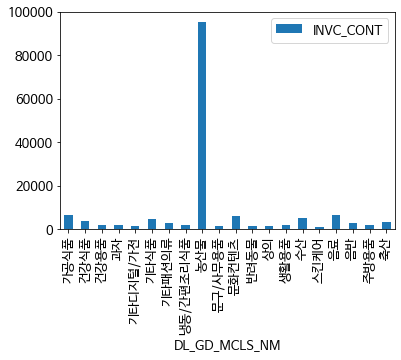

In [31]:
df.groupby('DL_GD_MCLS_NM').sum().plot.bar()

제공 받은 데이터는 송화인이나 수화인 둘중 하나는 제주도이기에 처음에는 송화인이 제주도일 때, 수화인이 제주도일 때 두 가지로 데이터 프레임을 분할하여 모델링을 하였습니다. 
(구글링으로 제주도의 지역구 코드는 '50'으로 시작하는 것을 파악하였으며 이를 기준으로 나눌 수 있었습니다.)

모델링하기 전 변수 중요도를 파악하는 과정에서 수화인 주소 즉 'REC_SPG_INNB' 컬럼의 점수가 낮게 나왔습니다. 따라서 원점으로 돌아가 원래의 데이터에서 수화인 주소를 제거한 후 모델링을 다시 하였습니다.

## Label Encoding

In [32]:
LE1 = LabelEncoder()
LE2 = LabelEncoder()
LE3 = LabelEncoder()

y_train = X_train[['INVC_CONT']]
X_train.drop(columns=['index', 'REC_SPG_INNB', 'DL_GD_LCLS_NM', 'INVC_CONT'], inplace=True)

X_train['SEND_SPG_INNB'] = LE1.fit_transform(X_train['SEND_SPG_INNB'])
# X_train['REC_SPG_INNB'] = LE2.fit_transform(X_train['REC_SPG_INNB'])
X_train['DL_GD_MCLS_NM'] = LE3.fit_transform(X_train['DL_GD_MCLS_NM'])

for label in np.unique(X_test['SEND_SPG_INNB']):
    if label not in LE1.classes_:
        LE1.classes_ = np.append(LE1.classes_, label)
        
# for label in np.unique(X_test['REC_SPG_INNB']):
#     if label not in LE2.classes_:
#         LE2.classes_ = np.append(LE2.classes_, label)
        
y_index = X_test[['index']]
X_test.drop(columns=['index', 'REC_SPG_INNB', 'DL_GD_LCLS_NM'], inplace=True)

X_test['SEND_SPG_INNB'] = LE1.transform(X_test['SEND_SPG_INNB'])
# X_test['REC_SPG_INNB'] = LE2.transform(X_test['REC_SPG_INNB'])
X_test['DL_GD_MCLS_NM'] = LE3.transform(X_test['DL_GD_MCLS_NM'])

라벨인코딩과 바이너리인코딩을 각각 사용해봤는데, 라벨 인코딩 성능이 더 좋게 나와서 라벨인코딩을 선택했습니다.

## Binary Encoding

In [33]:
# labelencoder = LabelEncoder()

# y_train = X_train[['INVC_CONT']]
# X_train.drop(columns=['index', 'REC_SPG_INNB', 'DL_GD_LCLS_NM', 'INVC_CONT'], inplace=True)
# binaryencoder = BinaryEncoder(cols=['DL_GD_MCLS_NM'], return_df=True)

# X_train = binaryencoder.fit_transform(X_train)
# X_train['SEND_SPG_INNB'] = labelencoder.fit_transform(X_train['SEND_SPG_INNB'])

# y_index = X_test[['index']]
# X_test.drop(columns=['index', 'REC_SPG_INNB', 'DL_GD_LCLS_NM'], inplace=True)
# X_test = binaryencoder.transform(X_test)
# X_test['SEND_SPG_INNB'] = labelencoder.transform(X_test['SEND_SPG_INNB'])

## 모델링

랜덤포레스트회귀, XGBoost회귀, 의사결정나무회귀 모델을 Grid Search에 넣어서 가장 좋은 하이퍼파라미터와 모델 조합을 찾아 선택할 수 있었습니다.

In [34]:
# pipe = Pipeline([('regressor', RandomForestRegressor())])
# search_space = [
#                 {
#                  'regressor': [RandomForestRegressor(random_state=0)],
#                  'regressor__n_estimators': [100, 150, 200],
#                  'regressor__max_depth': [3, 4, 5]
#                 },
                
#                 {
#                  'regressor': [XGBRegressor()],
#                  'regressor__max_depth': [3],
#                  'regressor__n_estimators': [300],
#                  'regressor__eta': [0.02, 0.1],
#                  'regressor__subsample': [0.5, 0.6],
#                  'regressor__seed':[0]
#                 },
                
#                 {
#                  'regressor': [DecisionTreeRegressor(random_state=0)],
#                  'regressor__min_samples_split':[3, 4, 5],
#                  'regressor__max_depth': [3, 4, 5]
#                 }
#                ]

In [35]:
# kf = KFold(n_splits=9,random_state=None)
# grid_search = GridSearchCV(pipe,search_space, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train.values.ravel())

# print('best params:', grid_search.best_params_)
# print('best estimator:', grid_search.best_estimator_)
# print('best rmse :', sqrt(-(grid_search.best_score_)))

In [ ]:
def objective(trial: Trial) -> float:
    params_xgb = {
        "random_state": 0,
        "learning_rate": 0.01,
        "n_estimators": trial.suggest_int("n_estimators", 2, 10000),
        "gamma": trial.suggest_float("gamma", 0.0, 100.0),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.4, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 2.0),
        "base_score": 4,
        "n_jobs": -1,
    }
    
    X_TRAIN, X_VAL, Y_TRAIN, Y_VAL = train_test_split(X_train, y_train, test_size=0.2)

    model = XGBRegressor(**params_xgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_TRAIN, Y_TRAIN), (X_VAL, Y_VAL)],
        early_stopping_rounds=10,
        verbose=100,
    )

    xgb_pred = model.predict(X_VAL)
    score = sqrt(mean_squared_error(Y_VAL, xgb_pred))
    
    return score

In [ ]:
sampler = TPESampler(seed=0)
study = optuna.create_study(
    study_name="xgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=50) # 보통 50~100 , 10번만 해도됨.
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-12-23 00:01:35,098] A new study created in memory with name: xgbm_parameter_opt


[0]	validation_0-rmse:5.71396	validation_1-rmse:6.13152
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.5476	validation_1-rmse:5.95933
[200]	validation_0-rmse:5.47536	validation_1-rmse:5.87956
[300]	validation_0-rmse:5.43368	validation_1-rmse:5.83165
[400]	validation_0-rmse:5.40665	validation_1-rmse:5.79905
[500]	validation_0-rmse:5.38838	validation_1-rmse:5.77904
[600]	validation_0-rmse:5.37148	validation_1-rmse:5.7604
[700]	validation_0-rmse:5.35613	validation_1-rmse:5.74411
[800]	validation_0-rmse:5.34366	validation_1-rmse:5.73089
[900]	validation_0-rmse:5.32881	validation_1-rmse:5.71529
[1000]	validation_0-rmse:5.31604	validation_1-rmse:5.70229
[1100]	validation_0-rmse:5.3056	validation_1-rmse:5.69203
[1200]	validation_0-rmse:5.29555	validation_1-rmse:5.68209
[1300]	validation_0-rmse:5.2864	validation_1-rmse:5.67322
[1400]	validation_0-rmse:5.2799

[I 2021-12-23 00:03:13,647] Trial 0 finished with value: 5.563586728045682 and parameters: {'n_estimators': 5489, 'gamma': 71.51893663724195, 'reg_alpha': 60.27633761113676, 'reg_lambda': 54.488318304240856, 'max_depth': 43, 'colsample_bytree': 0.7875364678399936, 'colsample_bylevel': 0.6625523267576154, 'colsample_bynode': 0.9350638004692479, 'subsample': 0.9745639323507205, 'min_child_weight': 39, 'scale_pos_weight': 1.6875875571239969}. Best is trial 0 with value: 5.563586728045682.


[0]	validation_0-rmse:6.01373	validation_1-rmse:4.85074
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.84895	validation_1-rmse:4.71284
[200]	validation_0-rmse:5.78701	validation_1-rmse:4.67912
[300]	validation_0-rmse:5.75435	validation_1-rmse:4.67053
Stopping. Best iteration:
[353]	validation_0-rmse:5.74141	validation_1-rmse:4.66839



[I 2021-12-23 00:03:20,387] Trial 1 finished with value: 4.668395155428837 and parameters: {'n_estimators': 5290, 'gamma': 56.80445610939323, 'reg_alpha': 92.55966383001014, 'reg_lambda': 7.103605829078334, 'max_depth': 9, 'colsample_bytree': 0.41213103846419546, 'colsample_bylevel': 0.8995719073287628, 'colsample_bynode': 0.8668940505699103, 'subsample': 0.9090085037727733, 'min_child_weight': 98, 'scale_pos_weight': 1.6987378463250855}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.86355	validation_1-rmse:5.54111
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.72752	validation_1-rmse:5.40918
[200]	validation_0-rmse:5.67501	validation_1-rmse:5.36368
[300]	validation_0-rmse:5.64615	validation_1-rmse:5.34108
[400]	validation_0-rmse:5.62857	validation_1-rmse:5.32721
[500]	validation_0-rmse:5.6163	validation_1-rmse:5.31887
[600]	validation_0-rmse:5.60486	validation_1-rmse:5.31016
[700]	validation_0-rmse:5.59494	validation_1-rmse:5.30286
[800]	validation_0-rmse:5.58681	validation_1-rmse:5.29604
[900]	validation_0-rmse:5.57697	validation_1-rmse:5.28819
[1000]	validation_0-rmse:5.56806	validation_1-rmse:5.28107
[1100]	validation_0-rmse:5.56067	validation_1-rmse:5.27356
[1200]	validation_0-rmse:5.55331	validation_1-rmse:5.26748
[1300]	validation_0-rmse:5.54656	validation_1-rmse:5.26132
[1400]	validation_0-rmse:5.5

[I 2021-12-23 00:04:36,937] Trial 2 finished with value: 5.169733349007194 and parameters: {'n_estimators': 4616, 'gamma': 78.05291762864555, 'reg_alpha': 11.827442595710579, 'reg_lambda': 63.992102136353175, 'max_depth': 15, 'colsample_bytree': 0.9668013502297503, 'colsample_bylevel': 0.7131089930500429, 'colsample_bynode': 0.6487971639943142, 'subsample': 0.48518892847323886, 'min_child_weight': 78, 'scale_pos_weight': 1.1842254983248228}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.91759	validation_1-rmse:5.30528
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.77377	validation_1-rmse:5.18779
[200]	validation_0-rmse:5.71476	validation_1-rmse:5.15822
[300]	validation_0-rmse:5.67849	validation_1-rmse:5.14761
[400]	validation_0-rmse:5.65423	validation_1-rmse:5.1433
Stopping. Best iteration:
[427]	validation_0-rmse:5.64934	validation_1-rmse:5.14297



[I 2021-12-23 00:04:46,333] Trial 3 finished with value: 5.142973797554374 and parameters: {'n_estimators': 5685, 'gamma': 1.8789800436355142, 'reg_alpha': 61.76354971141136, 'reg_lambda': 61.209572276121186, 'max_depth': 62, 'colsample_bytree': 0.9662488471087745, 'colsample_bylevel': 0.80909217946209, 'colsample_bynode': 0.6157047403442716, 'subsample': 0.605922367659539, 'min_child_weight': 70, 'scale_pos_weight': 0.5903382074439047}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.65553	validation_1-rmse:6.32834
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.37154	validation_1-rmse:5.92153
[200]	validation_0-rmse:5.23829	validation_1-rmse:5.69424
[300]	validation_0-rmse:5.16198	validation_1-rmse:5.55276
[400]	validation_0-rmse:5.11548	validation_1-rmse:5.45274
[500]	validation_0-rmse:5.09196	validation_1-rmse:5.39611
[600]	validation_0-rmse:5.07392	validation_1-rmse:5.35032
[700]	validation_0-rmse:5.05975	validation_1-rmse:5.3151
[800]	validation_0-rmse:5.05033	validation_1-rmse:5.2911
[900]	validation_0-rmse:5.04157	validation_1-rmse:5.26807
[1000]	validation_0-rmse:5.03536	validation_1-rmse:5.2517
[1100]	validation_0-rmse:5.03096	validation_1-rmse:5.24046
[1200]	validation_0-rmse:5.02749	validation_1-rmse:5.23121
[1300]	validation_0-rmse:5.02424	validation_1-rmse:5.22401
[1400]	validation_0-rmse:5.022

[I 2021-12-23 00:05:42,409] Trial 4 finished with value: 5.199265582810555 and parameters: {'n_estimators': 6669, 'gamma': 67.06378696181594, 'reg_alpha': 21.038256115280266, 'reg_lambda': 12.892629774196068, 'max_depth': 32, 'colsample_bytree': 0.6182264625655736, 'colsample_bylevel': 0.7421180622507277, 'colsample_bynode': 0.6631609080773921, 'subsample': 0.9918616866414582, 'min_child_weight': 11, 'scale_pos_weight': 0.813315134142252}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.98718	validation_1-rmse:4.98342
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.83605	validation_1-rmse:4.86431
[200]	validation_0-rmse:5.76734	validation_1-rmse:4.82674
[300]	validation_0-rmse:5.72198	validation_1-rmse:4.8083
[400]	validation_0-rmse:5.69083	validation_1-rmse:4.79913
[500]	validation_0-rmse:5.66983	validation_1-rmse:4.79285
Stopping. Best iteration:
[531]	validation_0-rmse:5.66249	validation_1-rmse:4.79104



[I 2021-12-23 00:05:54,609] Trial 5 finished with value: 4.791042496746575 and parameters: {'n_estimators': 1614, 'gamma': 65.31083254653984, 'reg_alpha': 25.3291602614453, 'reg_lambda': 46.631077290967525, 'max_depth': 25, 'colsample_bytree': 0.49538175018731184, 'colsample_bylevel': 0.4662250846985831, 'colsample_bynode': 0.793797753679164, 'subsample': 0.39672806594402965, 'min_child_weight': 20, 'scale_pos_weight': 1.0530877559914462}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.77493	validation_1-rmse:5.88549
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.48995	validation_1-rmse:5.64492
[200]	validation_0-rmse:5.33742	validation_1-rmse:5.52351
[300]	validation_0-rmse:5.23822	validation_1-rmse:5.44351
[400]	validation_0-rmse:5.17474	validation_1-rmse:5.39049
[500]	validation_0-rmse:5.1376	validation_1-rmse:5.35627
[600]	validation_0-rmse:5.10991	validation_1-rmse:5.32992
[700]	validation_0-rmse:5.08831	validation_1-rmse:5.30591
[800]	validation_0-rmse:5.07437	validation_1-rmse:5.29013
[900]	validation_0-rmse:5.06084	validation_1-rmse:5.27461
[1000]	validation_0-rmse:5.05122	validation_1-rmse:5.26463
[1100]	validation_0-rmse:5.04439	validation_1-rmse:5.25645
[1200]	validation_0-rmse:5.03892	validation_1-rmse:5.25048
[1300]	validation_0-rmse:5.03445	validation_1-rmse:5.24563
Stopping. Best iteration:
[1

[I 2021-12-23 00:06:22,293] Trial 6 finished with value: 5.245563060293022 and parameters: {'n_estimators': 8211, 'gamma': 9.710127579306127, 'reg_alpha': 83.79449075150094, 'reg_lambda': 9.609840798435323, 'max_depth': 98, 'colsample_bytree': 0.681190720988621, 'colsample_bylevel': 0.9860566529142023, 'colsample_bynode': 0.7629073118470275, 'subsample': 0.8174845055788111, 'min_child_weight': 4, 'scale_pos_weight': 0.9242104438646144}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.83933	validation_1-rmse:5.63955
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.67939	validation_1-rmse:5.48764
[200]	validation_0-rmse:5.61367	validation_1-rmse:5.42991
[300]	validation_0-rmse:5.57589	validation_1-rmse:5.40053
[400]	validation_0-rmse:5.55146	validation_1-rmse:5.3828
[500]	validation_0-rmse:5.53529	validation_1-rmse:5.36981
[600]	validation_0-rmse:5.51887	validation_1-rmse:5.35764
[700]	validation_0-rmse:5.50395	validation_1-rmse:5.3468
[800]	validation_0-rmse:5.49191	validation_1-rmse:5.33692
[900]	validation_0-rmse:5.47685	validation_1-rmse:5.32514
[1000]	validation_0-rmse:5.4636	validation_1-rmse:5.31384
[1100]	validation_0-rmse:5.45171	validation_1-rmse:5.30462
[1200]	validation_0-rmse:5.44047	validation_1-rmse:5.2948
[1202]	validation_0-rmse:5.44046	validation_1-rmse:5.2948


[I 2021-12-23 00:06:53,275] Trial 7 finished with value: 5.294761520917911 and parameters: {'n_estimators': 1203, 'gamma': 29.614019752214492, 'reg_alpha': 11.87277190423713, 'reg_lambda': 31.79831794621777, 'max_depth': 42, 'colsample_bytree': 0.4384884978092706, 'colsample_bylevel': 0.815483271622012, 'colsample_bynode': 0.739960872523945, 'subsample': 0.48577264365761175, 'min_child_weight': 53, 'scale_pos_weight': 0.6409107661376625}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.86304	validation_1-rmse:5.54147
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.69492	validation_1-rmse:5.41495
[200]	validation_0-rmse:5.60851	validation_1-rmse:5.37086
[300]	validation_0-rmse:5.54419	validation_1-rmse:5.34534
[400]	validation_0-rmse:5.49414	validation_1-rmse:5.32883
[500]	validation_0-rmse:5.45895	validation_1-rmse:5.3175
[600]	validation_0-rmse:5.4259	validation_1-rmse:5.3079
[700]	validation_0-rmse:5.39469	validation_1-rmse:5.29944
[800]	validation_0-rmse:5.3685	validation_1-rmse:5.29298
[900]	validation_0-rmse:5.33924	validation_1-rmse:5.28644
[1000]	validation_0-rmse:5.31514	validation_1-rmse:5.27988
[1100]	validation_0-rmse:5.29436	validation_1-rmse:5.27463
[1200]	validation_0-rmse:5.27614	validation_1-rmse:5.26974
[1300]	validation_0-rmse:5.2592	validation_1-rmse:5.26539
[1400]	validation_0-rmse:5.24685

[I 2021-12-23 00:07:44,809] Trial 8 finished with value: 5.229115349386858 and parameters: {'n_estimators': 5760, 'gamma': 92.92961975762141, 'reg_alpha': 31.85689525194668, 'reg_lambda': 66.74103799969406, 'max_depth': 14, 'colsample_bytree': 0.8297963224711393, 'colsample_bylevel': 0.5736436557683207, 'colsample_bynode': 0.5099148172042701, 'subsample': 0.7105590543670581, 'min_child_weight': 3, 'scale_pos_weight': 1.7434100438260447}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.57474	validation_1-rmse:6.62603
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[47]	validation_0-rmse:5.48285	validation_1-rmse:6.53501


[I 2021-12-23 00:07:45,818] Trial 9 finished with value: 6.535007513097123 and parameters: {'n_estimators': 48, 'gamma': 67.781653679623, 'reg_alpha': 27.00079732651641, 'reg_lambda': 73.51940221490754, 'max_depth': 97, 'colsample_bytree': 0.5492518861119748, 'colsample_bylevel': 0.7456944006507021, 'colsample_bynode': 0.7552251587631034, 'subsample': 0.7005763340536113, 'min_child_weight': 23, 'scale_pos_weight': 1.9291235172754775}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.71209	validation_1-rmse:6.14422
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.60555	validation_1-rmse:6.03947
[200]	validation_0-rmse:5.5717	validation_1-rmse:6.00597
[300]	validation_0-rmse:5.55261	validation_1-rmse:5.98642
[400]	validation_0-rmse:5.53641	validation_1-rmse:5.97018
[500]	validation_0-rmse:5.52423	validation_1-rmse:5.95789
[600]	validation_0-rmse:5.51451	validation_1-rmse:5.9478
[700]	validation_0-rmse:5.50585	validation_1-rmse:5.93848
[800]	validation_0-rmse:5.49823	validation_1-rmse:5.93032
[900]	validation_0-rmse:5.4901	validation_1-rmse:5.92141
[1000]	validation_0-rmse:5.48311	validation_1-rmse:5.91396
[1100]	validation_0-rmse:5.47674	validation_1-rmse:5.90749
[1200]	validation_0-rmse:5.47063	validation_1-rmse:5.90106
[1300]	validation_0-rmse:5.46467	validation_1-rmse:5.89483
[1400]	validation_0-rmse:5.460

[I 2021-12-23 00:08:28,526] Trial 10 finished with value: 5.8009804425240326 and parameters: {'n_estimators': 3398, 'gamma': 39.16687219748754, 'reg_alpha': 95.2778260864838, 'reg_lambda': 92.96403550348666, 'max_depth': 3, 'colsample_bytree': 0.40474257495651256, 'colsample_bylevel': 0.9232720591806775, 'colsample_bynode': 0.9785412454178335, 'subsample': 0.8503889937462696, 'min_child_weight': 100, 'scale_pos_weight': 1.504972180435706}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.59724	validation_1-rmse:6.55141
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.46469	validation_1-rmse:6.39678
[200]	validation_0-rmse:5.41511	validation_1-rmse:6.3274
[300]	validation_0-rmse:5.38761	validation_1-rmse:6.28383
[400]	validation_0-rmse:5.37053	validation_1-rmse:6.25133
[500]	validation_0-rmse:5.35875	validation_1-rmse:6.22997
[600]	validation_0-rmse:5.34873	validation_1-rmse:6.21042
[700]	validation_0-rmse:5.33971	validation_1-rmse:6.19246
[800]	validation_0-rmse:5.33244	validation_1-rmse:6.17928
[900]	validation_0-rmse:5.32227	validation_1-rmse:6.16124
[1000]	validation_0-rmse:5.31449	validation_1-rmse:6.14733
[1100]	validation_0-rmse:5.30787	validation_1-rmse:6.13639
[1200]	validation_0-rmse:5.30186	validation_1-rmse:6.12599
[1300]	validation_0-rmse:5.29547	validation_1-rmse:6.11412
Stopping. Best iteration:
[1

[I 2021-12-23 00:08:58,001] Trial 11 finished with value: 6.1055019167196924 and parameters: {'n_estimators': 3092, 'gamma': 51.393051355501825, 'reg_alpha': 42.767645820535336, 'reg_lambda': 36.204602516224156, 'max_depth': 24, 'colsample_bytree': 0.5028987185643765, 'colsample_bylevel': 0.40335809685774837, 'colsample_bynode': 0.870811562743445, 'subsample': 0.3515093756699131, 'min_child_weight': 36, 'scale_pos_weight': 1.2832452716206333}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.80925	validation_1-rmse:5.76688
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.68705	validation_1-rmse:5.65504
[200]	validation_0-rmse:5.64952	validation_1-rmse:5.62139
[300]	validation_0-rmse:5.63173	validation_1-rmse:5.6038
[400]	validation_0-rmse:5.62089	validation_1-rmse:5.59198
[500]	validation_0-rmse:5.61253	validation_1-rmse:5.58331
[600]	validation_0-rmse:5.60483	validation_1-rmse:5.57434
[700]	validation_0-rmse:5.59831	validation_1-rmse:5.56596
[800]	validation_0-rmse:5.59255	validation_1-rmse:5.55948
[900]	validation_0-rmse:5.58608	validation_1-rmse:5.55122
[1000]	validation_0-rmse:5.58013	validation_1-rmse:5.54439
[1100]	validation_0-rmse:5.57525	validation_1-rmse:5.538
[1200]	validation_0-rmse:5.57047	validation_1-rmse:5.53251
[1300]	validation_0-rmse:5.56554	validation_1-rmse:5.52734
Stopping. Best iteration:
[134

[I 2021-12-23 00:09:22,803] Trial 12 finished with value: 5.525648551895857 and parameters: {'n_estimators': 9245, 'gamma': 52.58923558091794, 'reg_alpha': 79.94072738844866, 'reg_lambda': 0.26322745392357216, 'max_depth': 67, 'colsample_bytree': 0.5203679205774774, 'colsample_bylevel': 0.4109865660986834, 'colsample_bynode': 0.8431102694537561, 'subsample': 0.31232044549170535, 'min_child_weight': 99, 'scale_pos_weight': 1.1244655195104785}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.79013	validation_1-rmse:5.84496
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.68779	validation_1-rmse:5.74302
[200]	validation_0-rmse:5.65652	validation_1-rmse:5.71299
[300]	validation_0-rmse:5.63591	validation_1-rmse:5.69644
[400]	validation_0-rmse:5.62077	validation_1-rmse:5.68452
[500]	validation_0-rmse:5.60819	validation_1-rmse:5.67627
[600]	validation_0-rmse:5.59422	validation_1-rmse:5.66841
[700]	validation_0-rmse:5.58312	validation_1-rmse:5.66254
[800]	validation_0-rmse:5.57303	validation_1-rmse:5.65819
[900]	validation_0-rmse:5.56198	validation_1-rmse:5.65321
[1000]	validation_0-rmse:5.55337	validation_1-rmse:5.64934
[1100]	validation_0-rmse:5.54505	validation_1-rmse:5.64608
Stopping. Best iteration:
[1101]	validation_0-rmse:5.54502	validation_1-rmse:5.64604



[I 2021-12-23 00:09:36,439] Trial 13 finished with value: 5.646025303371565 and parameters: {'n_estimators': 3098, 'gamma': 91.9049913320876, 'reg_alpha': 0.4030892970022464, 'reg_lambda': 30.826859079419993, 'max_depth': 2, 'colsample_bytree': 0.6118341994406091, 'colsample_bylevel': 0.5118792712626008, 'colsample_bynode': 0.8651224524197696, 'subsample': 0.5167726909403159, 'min_child_weight': 57, 'scale_pos_weight': 1.4093798165522362}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.6218	validation_1-rmse:6.46432
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.45985	validation_1-rmse:6.31771
[200]	validation_0-rmse:5.3975	validation_1-rmse:6.25933
[300]	validation_0-rmse:5.36372	validation_1-rmse:6.2266
[400]	validation_0-rmse:5.34115	validation_1-rmse:6.20486
[500]	validation_0-rmse:5.32624	validation_1-rmse:6.19042
[600]	validation_0-rmse:5.31228	validation_1-rmse:6.17633
[700]	validation_0-rmse:5.29961	validation_1-rmse:6.16411
[800]	validation_0-rmse:5.28878	validation_1-rmse:6.15297
[900]	validation_0-rmse:5.27661	validation_1-rmse:6.14003
[1000]	validation_0-rmse:5.2658	validation_1-rmse:6.12839
[1100]	validation_0-rmse:5.2566	validation_1-rmse:6.11737
[1200]	validation_0-rmse:5.24751	validation_1-rmse:6.10733
[1300]	validation_0-rmse:5.23849	validation_1-rmse:6.09824
[1400]	validation_0-rmse:5.23217

[I 2021-12-23 00:10:19,503] Trial 14 finished with value: 6.054754189600799 and parameters: {'n_estimators': 1841, 'gamma': 34.43205747905726, 'reg_alpha': 44.9873342814834, 'reg_lambda': 42.56487988071189, 'max_depth': 27, 'colsample_bytree': 0.4583282880282984, 'colsample_bylevel': 0.5819043683459274, 'colsample_bynode': 0.41107004745346387, 'subsample': 0.8357594166837851, 'min_child_weight': 82, 'scale_pos_weight': 1.993204414999259}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.92384	validation_1-rmse:5.27631
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.7682	validation_1-rmse:5.13535
[200]	validation_0-rmse:5.70002	validation_1-rmse:5.08109
[300]	validation_0-rmse:5.65871	validation_1-rmse:5.04959
[400]	validation_0-rmse:5.63271	validation_1-rmse:5.02976
[500]	validation_0-rmse:5.61491	validation_1-rmse:5.01483
[600]	validation_0-rmse:5.59924	validation_1-rmse:5.00192
[700]	validation_0-rmse:5.58494	validation_1-rmse:4.99098
[800]	validation_0-rmse:5.57353	validation_1-rmse:4.98068
[900]	validation_0-rmse:5.55859	validation_1-rmse:4.96795
[1000]	validation_0-rmse:5.54506	validation_1-rmse:4.95792
[1100]	validation_0-rmse:5.53548	validation_1-rmse:4.95023
[1200]	validation_0-rmse:5.52622	validation_1-rmse:4.94147
[1300]	validation_0-rmse:5.51699	validation_1-rmse:4.93382
[1400]	validation_0-rmse:5.5

[I 2021-12-23 00:11:26,262] Trial 15 finished with value: 4.813725979126424 and parameters: {'n_estimators': 7118, 'gamma': 60.14361250618682, 'reg_alpha': 58.69311720029516, 'reg_lambda': 20.109248101183915, 'max_depth': 14, 'colsample_bytree': 0.4015672956899725, 'colsample_bylevel': 0.9053178195523147, 'colsample_bynode': 0.8144426402554353, 'subsample': 0.4143475162706368, 'min_child_weight': 25, 'scale_pos_weight': 1.0467909368693962}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.84961	validation_1-rmse:5.59972
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.71996	validation_1-rmse:5.48483
[200]	validation_0-rmse:5.66476	validation_1-rmse:5.44637
[300]	validation_0-rmse:5.62823	validation_1-rmse:5.42739
[400]	validation_0-rmse:5.60218	validation_1-rmse:5.41704
[500]	validation_0-rmse:5.58425	validation_1-rmse:5.41194
[600]	validation_0-rmse:5.56927	validation_1-rmse:5.40738
[700]	validation_0-rmse:5.55645	validation_1-rmse:5.40383
Stopping. Best iteration:
[750]	validation_0-rmse:5.55107	validation_1-rmse:5.40203



[I 2021-12-23 00:11:42,380] Trial 16 finished with value: 5.402024773152726 and parameters: {'n_estimators': 4052, 'gamma': 21.77733552380606, 'reg_alpha': 77.0646694479368, 'reg_lambda': 99.16933285903411, 'max_depth': 55, 'colsample_bytree': 0.5880124322752965, 'colsample_bylevel': 0.6293982995695209, 'colsample_bynode': 0.9101103343890263, 'subsample': 0.6130297127823723, 'min_child_weight': 40, 'scale_pos_weight': 1.6036634546390696}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.67906	validation_1-rmse:6.26356
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.54847	validation_1-rmse:6.09508
[200]	validation_0-rmse:5.50256	validation_1-rmse:6.00944
[300]	validation_0-rmse:5.47927	validation_1-rmse:5.94889
[400]	validation_0-rmse:5.46599	validation_1-rmse:5.90169
[500]	validation_0-rmse:5.45866	validation_1-rmse:5.86988
[600]	validation_0-rmse:5.45215	validation_1-rmse:5.84209
[700]	validation_0-rmse:5.44619	validation_1-rmse:5.81749
[800]	validation_0-rmse:5.44171	validation_1-rmse:5.79547
[900]	validation_0-rmse:5.43673	validation_1-rmse:5.77193
[1000]	validation_0-rmse:5.43234	validation_1-rmse:5.75215
[1100]	validation_0-rmse:5.4288	validation_1-rmse:5.73415
[1200]	validation_0-rmse:5.42498	validation_1-rmse:5.71682
[1300]	validation_0-rmse:5.42158	validation_1-rmse:5.69871
[1400]	validation_0-rmse:5.4

[I 2021-12-23 00:12:23,209] Trial 17 finished with value: 5.6178972843332495 and parameters: {'n_estimators': 1876, 'gamma': 85.55050691161422, 'reg_alpha': 96.80386957417886, 'reg_lambda': 80.4104287767359, 'max_depth': 39, 'colsample_bytree': 0.7049617010482869, 'colsample_bylevel': 0.48818747083355885, 'colsample_bynode': 0.8009396228550748, 'subsample': 0.8827457442460848, 'min_child_weight': 62, 'scale_pos_weight': 1.3689572814037227}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:5.616	validation_1-rmse:6.48518
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.46899	validation_1-rmse:6.31699
[200]	validation_0-rmse:5.41622	validation_1-rmse:6.23998
[300]	validation_0-rmse:5.39004	validation_1-rmse:6.19045
[303]	validation_0-rmse:5.3894	validation_1-rmse:6.18905


[I 2021-12-23 00:12:29,678] Trial 18 finished with value: 6.18905073723169 and parameters: {'n_estimators': 304, 'gamma': 44.35444506714867, 'reg_alpha': 34.911428732741335, 'reg_lambda': 50.33293524321179, 'max_depth': 19, 'colsample_bytree': 0.4839996640808372, 'colsample_bylevel': 0.8421563814752662, 'colsample_bynode': 0.5640676980277974, 'subsample': 0.7457778385892334, 'min_child_weight': 87, 'scale_pos_weight': 0.8262372922906405}. Best is trial 1 with value: 4.668395155428837.


[0]	validation_0-rmse:6.01742	validation_1-rmse:4.83143
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.85057	validation_1-rmse:4.68378
[200]	validation_0-rmse:5.77603	validation_1-rmse:4.63739
[300]	validation_0-rmse:5.72573	validation_1-rmse:4.61761
[400]	validation_0-rmse:5.69244	validation_1-rmse:4.60904
[500]	validation_0-rmse:5.67014	validation_1-rmse:4.60468
Stopping. Best iteration:
[542]	validation_0-rmse:5.66109	validation_1-rmse:4.60163



[I 2021-12-23 00:12:41,635] Trial 19 finished with value: 4.601636128806186 and parameters: {'n_estimators': 7036, 'gamma': 57.84760467407078, 'reg_alpha': 72.26983143239273, 'reg_lambda': 23.080227367220527, 'max_depth': 82, 'colsample_bytree': 0.6920303751667014, 'colsample_bylevel': 0.9997933362721252, 'colsample_bynode': 0.9705740903134658, 'subsample': 0.5753291421288904, 'min_child_weight': 27, 'scale_pos_weight': 1.7885528737215601}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.98134	validation_1-rmse:5.00805
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.82323	validation_1-rmse:4.86984
[200]	validation_0-rmse:5.75893	validation_1-rmse:4.82987
[300]	validation_0-rmse:5.72011	validation_1-rmse:4.81186
[400]	validation_0-rmse:5.69521	validation_1-rmse:4.80268
[500]	validation_0-rmse:5.6779	validation_1-rmse:4.79562
Stopping. Best iteration:
[555]	validation_0-rmse:5.6677	validation_1-rmse:4.79147



[I 2021-12-23 00:12:53,928] Trial 20 finished with value: 4.791477573382062 and parameters: {'n_estimators': 7400, 'gamma': 56.289437839769825, 'reg_alpha': 69.8691587778101, 'reg_lambda': 18.78283150467823, 'max_depth': 85, 'colsample_bytree': 0.8772074007304522, 'colsample_bylevel': 0.976436753691491, 'colsample_bynode': 0.9751589673887882, 'subsample': 0.5546352366715916, 'min_child_weight': 45, 'scale_pos_weight': 1.8484971720794816}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.79346	validation_1-rmse:5.82425
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.6264	validation_1-rmse:5.66017
[200]	validation_0-rmse:5.55537	validation_1-rmse:5.59804
[300]	validation_0-rmse:5.51318	validation_1-rmse:5.56847
[400]	validation_0-rmse:5.48562	validation_1-rmse:5.55119
[500]	validation_0-rmse:5.46564	validation_1-rmse:5.53629
Stopping. Best iteration:
[562]	validation_0-rmse:5.45383	validation_1-rmse:5.52932



[I 2021-12-23 00:13:05,496] Trial 21 finished with value: 5.529312675323438 and parameters: {'n_estimators': 8366, 'gamma': 76.07819827714101, 'reg_alpha': 86.74196888404141, 'reg_lambda': 1.955531488784894, 'max_depth': 83, 'colsample_bytree': 0.6725719982826113, 'colsample_bylevel': 0.9105107468238345, 'colsample_bynode': 0.9279527883519769, 'subsample': 0.42460907590259417, 'min_child_weight': 25, 'scale_pos_weight': 1.7774559758843531}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.89205	validation_1-rmse:5.41747
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.74637	validation_1-rmse:5.27062
[200]	validation_0-rmse:5.68113	validation_1-rmse:5.21567
[300]	validation_0-rmse:5.63785	validation_1-rmse:5.18302
[400]	validation_0-rmse:5.60749	validation_1-rmse:5.16463
[500]	validation_0-rmse:5.58718	validation_1-rmse:5.15361
[600]	validation_0-rmse:5.5689	validation_1-rmse:5.14366
[700]	validation_0-rmse:5.55248	validation_1-rmse:5.13464
[800]	validation_0-rmse:5.53974	validation_1-rmse:5.12831
[900]	validation_0-rmse:5.52321	validation_1-rmse:5.12115
[1000]	validation_0-rmse:5.51037	validation_1-rmse:5.11357
[1100]	validation_0-rmse:5.50149	validation_1-rmse:5.10693
[1200]	validation_0-rmse:5.49244	validation_1-rmse:5.101
Stopping. Best iteration:
[1215]	validation_0-rmse:5.49056	validation_1-rmse:5.10004



[I 2021-12-23 00:13:30,811] Trial 22 finished with value: 5.100036798683825 and parameters: {'n_estimators': 6118, 'gamma': 64.62017705824793, 'reg_alpha': 71.30018990620457, 'reg_lambda': 25.87309101869748, 'max_depth': 78, 'colsample_bytree': 0.7494215259292996, 'colsample_bylevel': 0.9878022755011995, 'colsample_bynode': 0.8883895891340434, 'subsample': 0.3855850090961532, 'min_child_weight': 16, 'scale_pos_weight': 1.561917163952112}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.77703	validation_1-rmse:5.89141
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.62431	validation_1-rmse:5.76193
[200]	validation_0-rmse:5.55854	validation_1-rmse:5.71625
[300]	validation_0-rmse:5.51477	validation_1-rmse:5.69338
[400]	validation_0-rmse:5.48495	validation_1-rmse:5.682
[500]	validation_0-rmse:5.46493	validation_1-rmse:5.67477
[600]	validation_0-rmse:5.44727	validation_1-rmse:5.66964
[700]	validation_0-rmse:5.43153	validation_1-rmse:5.66533
[800]	validation_0-rmse:5.41743	validation_1-rmse:5.66253
Stopping. Best iteration:
[833]	validation_0-rmse:5.41253	validation_1-rmse:5.66199



[I 2021-12-23 00:13:46,287] Trial 23 finished with value: 5.6619815757842735 and parameters: {'n_estimators': 9879, 'gamma': 43.21352608275612, 'reg_alpha': 90.433699955502, 'reg_lambda': 42.825952761382126, 'max_depth': 8, 'colsample_bytree': 0.5585676639476949, 'colsample_bylevel': 0.863345838447229, 'colsample_bynode': 0.7068857609873177, 'subsample': 0.6561722551191889, 'min_child_weight': 31, 'scale_pos_weight': 0.9895567961195996}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.8553	validation_1-rmse:5.56771
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.65771	validation_1-rmse:5.41435
[200]	validation_0-rmse:5.56062	validation_1-rmse:5.36405
[300]	validation_0-rmse:5.49184	validation_1-rmse:5.33795
Stopping. Best iteration:
[357]	validation_0-rmse:5.46677	validation_1-rmse:5.3316



[I 2021-12-23 00:13:53,855] Trial 24 finished with value: 5.331598408534223 and parameters: {'n_estimators': 4803, 'gamma': 81.23957305088783, 'reg_alpha': 99.96858821468628, 'reg_lambda': 10.827455354313635, 'max_depth': 32, 'colsample_bytree': 0.4611332706211406, 'colsample_bylevel': 0.9350151058318674, 'colsample_bynode': 0.9891220969976967, 'subsample': 0.5776977487423719, 'min_child_weight': 14, 'scale_pos_weight': 1.424047000891616}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.95721	validation_1-rmse:5.12228
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.78831	validation_1-rmse:4.97017
[200]	validation_0-rmse:5.72064	validation_1-rmse:4.92565
[300]	validation_0-rmse:5.68347	validation_1-rmse:4.90929
[400]	validation_0-rmse:5.65717	validation_1-rmse:4.90102
[500]	validation_0-rmse:5.63924	validation_1-rmse:4.89649
[600]	validation_0-rmse:5.62184	validation_1-rmse:4.89277
Stopping. Best iteration:
[635]	validation_0-rmse:5.61552	validation_1-rmse:4.89151



[I 2021-12-23 00:14:08,349] Trial 25 finished with value: 4.891496858726648 and parameters: {'n_estimators': 4200, 'gamma': 59.431873544977876, 'reg_alpha': 51.406494003519924, 'reg_lambda': 21.84864936996228, 'max_depth': 51, 'colsample_bytree': 0.886707001371776, 'colsample_bylevel': 0.7676374374276715, 'colsample_bynode': 0.8037740853181802, 'subsample': 0.7664259767097268, 'min_child_weight': 67, 'scale_pos_weight': 1.2552048696074747}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.50633	validation_1-rmse:6.84899
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.34836	validation_1-rmse:6.65465
[200]	validation_0-rmse:5.28362	validation_1-rmse:6.55653
[300]	validation_0-rmse:5.24873	validation_1-rmse:6.49699
[400]	validation_0-rmse:5.22707	validation_1-rmse:6.4562
[500]	validation_0-rmse:5.21297	validation_1-rmse:6.4283
[600]	validation_0-rmse:5.19995	validation_1-rmse:6.40343
[700]	validation_0-rmse:5.18839	validation_1-rmse:6.38108
[800]	validation_0-rmse:5.17971	validation_1-rmse:6.36433
[900]	validation_0-rmse:5.16954	validation_1-rmse:6.34592
[1000]	validation_0-rmse:5.16071	validation_1-rmse:6.33038
[1100]	validation_0-rmse:5.15332	validation_1-rmse:6.31778
[1200]	validation_0-rmse:5.14655	validation_1-rmse:6.30633
[1300]	validation_0-rmse:5.14002	validation_1-rmse:6.29537
[1400]	validation_0-rmse:5.13

[I 2021-12-23 00:15:33,230] Trial 26 finished with value: 6.1422649658699005 and parameters: {'n_estimators': 7870, 'gamma': 49.555963260779244, 'reg_alpha': 76.73520598635068, 'reg_lambda': 39.70298894207919, 'max_depth': 66, 'colsample_bytree': 0.5207088473506966, 'colsample_bylevel': 0.88039178248205, 'colsample_bynode': 0.9451670912406094, 'subsample': 0.909116703598271, 'min_child_weight': 48, 'scale_pos_weight': 1.8738231802929532}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.54354	validation_1-rmse:6.72442
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.32098	validation_1-rmse:6.52646
[200]	validation_0-rmse:5.22244	validation_1-rmse:6.43802
[300]	validation_0-rmse:5.15788	validation_1-rmse:6.381
[400]	validation_0-rmse:5.11671	validation_1-rmse:6.34594
[500]	validation_0-rmse:5.09109	validation_1-rmse:6.3232
[600]	validation_0-rmse:5.06916	validation_1-rmse:6.30283
[700]	validation_0-rmse:5.04952	validation_1-rmse:6.2844
[800]	validation_0-rmse:5.03229	validation_1-rmse:6.27109
[900]	validation_0-rmse:5.01513	validation_1-rmse:6.2542
[1000]	validation_0-rmse:5.00201	validation_1-rmse:6.23863
[1100]	validation_0-rmse:4.98988	validation_1-rmse:6.22531
[1200]	validation_0-rmse:4.97919	validation_1-rmse:6.21553
[1300]	validation_0-rmse:4.96907	validation_1-rmse:6.20649
[1400]	validation_0-rmse:4.96186

[I 2021-12-23 00:16:42,125] Trial 27 finished with value: 6.103117281724643 and parameters: {'n_estimators': 6317, 'gamma': 73.49073458045453, 'reg_alpha': 67.3391429715396, 'reg_lambda': 6.098572957455177, 'max_depth': 75, 'colsample_bytree': 0.6354532392996681, 'colsample_bylevel': 0.45773623349968257, 'colsample_bynode': 0.8309861798758533, 'subsample': 0.6554470823271261, 'min_child_weight': 18, 'scale_pos_weight': 1.6470205147748913}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.93937	validation_1-rmse:5.20354
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.7749	validation_1-rmse:5.05404
[200]	validation_0-rmse:5.7046	validation_1-rmse:5.003
[300]	validation_0-rmse:5.66167	validation_1-rmse:4.97884
[400]	validation_0-rmse:5.63383	validation_1-rmse:4.96604
[500]	validation_0-rmse:5.61418	validation_1-rmse:4.95707
Stopping. Best iteration:
[560]	validation_0-rmse:5.60224	validation_1-rmse:4.95267



[I 2021-12-23 00:16:54,714] Trial 28 finished with value: 4.952662200877777 and parameters: {'n_estimators': 2301, 'gamma': 24.96871155144737, 'reg_alpha': 51.35938627820253, 'reg_lambda': 15.896344138902563, 'max_depth': 23, 'colsample_bytree': 0.7387767279993434, 'colsample_bylevel': 0.9459061673258362, 'colsample_bynode': 0.8946050163548503, 'subsample': 0.46198839467903613, 'min_child_weight': 33, 'scale_pos_weight': 1.5061499115967707}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.67357	validation_1-rmse:6.28143
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.5303	validation_1-rmse:6.09654
[200]	validation_0-rmse:5.47978	validation_1-rmse:6.01334
[300]	validation_0-rmse:5.45552	validation_1-rmse:5.96508
[400]	validation_0-rmse:5.44102	validation_1-rmse:5.93254
[500]	validation_0-rmse:5.4319	validation_1-rmse:5.9093
[600]	validation_0-rmse:5.42331	validation_1-rmse:5.89002
[700]	validation_0-rmse:5.41564	validation_1-rmse:5.87271
[800]	validation_0-rmse:5.40883	validation_1-rmse:5.85796
[900]	validation_0-rmse:5.40058	validation_1-rmse:5.84073
[1000]	validation_0-rmse:5.39319	validation_1-rmse:5.82532
[1100]	validation_0-rmse:5.3863	validation_1-rmse:5.81171
[1200]	validation_0-rmse:5.38007	validation_1-rmse:5.79928
[1300]	validation_0-rmse:5.3737	validation_1-rmse:5.78707
[1400]	validation_0-rmse:5.36939

[I 2021-12-23 00:17:47,694] Trial 29 finished with value: 5.620519228655719 and parameters: {'n_estimators': 5431, 'gamma': 64.5194727860466, 'reg_alpha': 57.42992459200879, 'reg_lambda': 54.84121058929136, 'max_depth': 8, 'colsample_bytree': 0.7946382115872568, 'colsample_bylevel': 0.676036649775411, 'colsample_bynode': 0.938219549459135, 'subsample': 0.9506680336951825, 'min_child_weight': 90, 'scale_pos_weight': 1.6978629946927934}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.76028	validation_1-rmse:5.95605
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.6175	validation_1-rmse:5.80684
[200]	validation_0-rmse:5.5629	validation_1-rmse:5.73966
[300]	validation_0-rmse:5.53221	validation_1-rmse:5.69083
[400]	validation_0-rmse:5.51416	validation_1-rmse:5.65625
[500]	validation_0-rmse:5.50179	validation_1-rmse:5.63291
[600]	validation_0-rmse:5.49102	validation_1-rmse:5.60973
[700]	validation_0-rmse:5.48132	validation_1-rmse:5.58975
[800]	validation_0-rmse:5.47361	validation_1-rmse:5.57361
[900]	validation_0-rmse:5.46448	validation_1-rmse:5.55299
[1000]	validation_0-rmse:5.45652	validation_1-rmse:5.53723
[1100]	validation_0-rmse:5.44972	validation_1-rmse:5.52134
[1200]	validation_0-rmse:5.44297	validation_1-rmse:5.50497
[1300]	validation_0-rmse:5.4368	validation_1-rmse:5.49281
[1400]	validation_0-rmse:5.432

[I 2021-12-23 00:18:37,595] Trial 30 finished with value: 5.363012348479741 and parameters: {'n_estimators': 8806, 'gamma': 45.53109384794836, 'reg_alpha': 90.96998365693275, 'reg_lambda': 27.825469235822, 'max_depth': 36, 'colsample_bytree': 0.4364342657424131, 'colsample_bylevel': 0.6244758050996159, 'colsample_bynode': 0.7792339771807621, 'subsample': 0.5485023043684781, 'min_child_weight': 40, 'scale_pos_weight': 1.8001592371813584}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.52083	validation_1-rmse:6.80176
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.36845	validation_1-rmse:6.62279
[200]	validation_0-rmse:5.31506	validation_1-rmse:6.54003
[300]	validation_0-rmse:5.28696	validation_1-rmse:6.48325
[400]	validation_0-rmse:5.27015	validation_1-rmse:6.4425
[500]	validation_0-rmse:5.25838	validation_1-rmse:6.41401
[600]	validation_0-rmse:5.24794	validation_1-rmse:6.38585
[700]	validation_0-rmse:5.2381	validation_1-rmse:6.36001
[800]	validation_0-rmse:5.22961	validation_1-rmse:6.33934
[900]	validation_0-rmse:5.21987	validation_1-rmse:6.31321
[1000]	validation_0-rmse:5.21158	validation_1-rmse:6.29378
[1100]	validation_0-rmse:5.20424	validation_1-rmse:6.27434
[1200]	validation_0-rmse:5.19698	validation_1-rmse:6.25593
[1300]	validation_0-rmse:5.19048	validation_1-rmse:6.24092
[1400]	validation_0-rmse:5.18

[I 2021-12-23 00:19:30,810] Trial 31 finished with value: 6.085379726411888 and parameters: {'n_estimators': 7317, 'gamma': 57.41841235568518, 'reg_alpha': 69.60086598497026, 'reg_lambda': 15.961788067623377, 'max_depth': 92, 'colsample_bytree': 0.8849337838551574, 'colsample_bylevel': 0.9966813018962339, 'colsample_bynode': 0.9956046037821848, 'subsample': 0.5639769595209849, 'min_child_weight': 46, 'scale_pos_weight': 1.8744472100236926}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.86618	validation_1-rmse:5.52531
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.70055	validation_1-rmse:5.37376
[200]	validation_0-rmse:5.62969	validation_1-rmse:5.31487
[300]	validation_0-rmse:5.58446	validation_1-rmse:5.28007
[400]	validation_0-rmse:5.55614	validation_1-rmse:5.25923
[500]	validation_0-rmse:5.53665	validation_1-rmse:5.24599
[600]	validation_0-rmse:5.51811	validation_1-rmse:5.23318
[700]	validation_0-rmse:5.50161	validation_1-rmse:5.22275
[800]	validation_0-rmse:5.48921	validation_1-rmse:5.21373
[900]	validation_0-rmse:5.47355	validation_1-rmse:5.20403
[1000]	validation_0-rmse:5.46093	validation_1-rmse:5.19496
[1100]	validation_0-rmse:5.44937	validation_1-rmse:5.18763
[1200]	validation_0-rmse:5.43836	validation_1-rmse:5.18075
[1300]	validation_0-rmse:5.42851	validation_1-rmse:5.17473
[1400]	validation_0-rmse:5.

[I 2021-12-23 00:20:20,772] Trial 32 finished with value: 5.129648884664123 and parameters: {'n_estimators': 7303, 'gamma': 55.978268683063376, 'reg_alpha': 65.32646104738825, 'reg_lambda': 20.990861804427443, 'max_depth': 87, 'colsample_bytree': 0.873189295273222, 'colsample_bylevel': 0.9600474559352378, 'colsample_bynode': 0.9557892304021203, 'subsample': 0.5264642073730857, 'min_child_weight': 28, 'scale_pos_weight': 1.9964394383487476}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.6948	validation_1-rmse:6.20007
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.52396	validation_1-rmse:6.02797
[200]	validation_0-rmse:5.46338	validation_1-rmse:5.96669
[300]	validation_0-rmse:5.42549	validation_1-rmse:5.93367
[400]	validation_0-rmse:5.40042	validation_1-rmse:5.91338
[500]	validation_0-rmse:5.38296	validation_1-rmse:5.8984
[600]	validation_0-rmse:5.36731	validation_1-rmse:5.88532
[700]	validation_0-rmse:5.35232	validation_1-rmse:5.87368
[800]	validation_0-rmse:5.33884	validation_1-rmse:5.86423
[900]	validation_0-rmse:5.32281	validation_1-rmse:5.85326
[1000]	validation_0-rmse:5.30995	validation_1-rmse:5.84445
[1100]	validation_0-rmse:5.29798	validation_1-rmse:5.83754
[1200]	validation_0-rmse:5.28686	validation_1-rmse:5.8305
[1300]	validation_0-rmse:5.27677	validation_1-rmse:5.82452
Stopping. Best iteration:
[131

[I 2021-12-23 00:20:50,377] Trial 33 finished with value: 5.823910570902356 and parameters: {'n_estimators': 5173, 'gamma': 73.58627418149821, 'reg_alpha': 74.47389575713402, 'reg_lambda': 5.17705532066098, 'max_depth': 74, 'colsample_bytree': 0.9261536705434824, 'colsample_bylevel': 0.9665789119756338, 'colsample_bynode': 0.8524668678619785, 'subsample': 0.6181510544412941, 'min_child_weight': 44, 'scale_pos_weight': 1.8056649012946262}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:5.60329	validation_1-rmse:6.53032
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.4706	validation_1-rmse:6.40752
[200]	validation_0-rmse:5.40896	validation_1-rmse:6.34913
[300]	validation_0-rmse:5.36651	validation_1-rmse:6.30717
[400]	validation_0-rmse:5.33619	validation_1-rmse:6.27736
[500]	validation_0-rmse:5.31405	validation_1-rmse:6.254
[600]	validation_0-rmse:5.2922	validation_1-rmse:6.23192
[700]	validation_0-rmse:5.2723	validation_1-rmse:6.21019
[800]	validation_0-rmse:5.25697	validation_1-rmse:6.19292
[900]	validation_0-rmse:5.23868	validation_1-rmse:6.17325
[1000]	validation_0-rmse:5.22401	validation_1-rmse:6.15681
[1100]	validation_0-rmse:5.21206	validation_1-rmse:6.14227
[1200]	validation_0-rmse:5.20074	validation_1-rmse:6.12893
[1300]	validation_0-rmse:5.19101	validation_1-rmse:6.11613
[1400]	validation_0-rmse:5.18396

[I 2021-12-23 00:21:57,240] Trial 34 finished with value: 5.9741145681571926 and parameters: {'n_estimators': 6721, 'gamma': 68.01424556952072, 'reg_alpha': 83.08680753092193, 'reg_lambda': 57.51195976410024, 'max_depth': 56, 'colsample_bytree': 0.989084775693829, 'colsample_bylevel': 0.8007655792524881, 'colsample_bynode': 0.9126604992772817, 'subsample': 0.47616223117524925, 'min_child_weight': 8, 'scale_pos_weight': 1.1755125964869313}. Best is trial 19 with value: 4.601636128806186.


[0]	validation_0-rmse:6.1047	validation_1-rmse:4.37953
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.98732	validation_1-rmse:4.25746
[200]	validation_0-rmse:5.94551	validation_1-rmse:4.22548
[300]	validation_0-rmse:5.9234	validation_1-rmse:4.21472
[400]	validation_0-rmse:5.90873	validation_1-rmse:4.21032
[500]	validation_0-rmse:5.89853	validation_1-rmse:4.20671
[600]	validation_0-rmse:5.88972	validation_1-rmse:4.20465
Stopping. Best iteration:
[629]	validation_0-rmse:5.88773	validation_1-rmse:4.20378



[I 2021-12-23 00:22:09,573] Trial 35 finished with value: 4.20379573515955 and parameters: {'n_estimators': 7790, 'gamma': 81.51218994408325, 'reg_alpha': 41.20558214754986, 'reg_lambda': 48.92343084462546, 'max_depth': 87, 'colsample_bytree': 0.7765121567321774, 'colsample_bylevel': 0.8845446109606251, 'colsample_bynode': 0.9380640843683188, 'subsample': 0.30286925503887835, 'min_child_weight': 71, 'scale_pos_weight': 1.6647907213904354}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.74704	validation_1-rmse:6.01118
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.63058	validation_1-rmse:5.89714
[200]	validation_0-rmse:5.59043	validation_1-rmse:5.86233
[300]	validation_0-rmse:5.57085	validation_1-rmse:5.84601
[400]	validation_0-rmse:5.55781	validation_1-rmse:5.8386
Stopping. Best iteration:
[488]	validation_0-rmse:5.54946	validation_1-rmse:5.83401



[I 2021-12-23 00:22:19,087] Trial 36 finished with value: 5.834005721046282 and parameters: {'n_estimators': 4262, 'gamma': 99.07410691405128, 'reg_alpha': 39.1004101092801, 'reg_lambda': 50.98373427222003, 'max_depth': 46, 'colsample_bytree': 0.8073298066388329, 'colsample_bylevel': 0.6991033012619509, 'colsample_bynode': 0.7177327662136257, 'subsample': 0.305734786939572, 'min_child_weight': 78, 'scale_pos_weight': 1.673234644314091}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:6.02894	validation_1-rmse:4.77968
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.89948	validation_1-rmse:4.6406
[200]	validation_0-rmse:5.85303	validation_1-rmse:4.59844
[300]	validation_0-rmse:5.82786	validation_1-rmse:4.58061
[400]	validation_0-rmse:5.81055	validation_1-rmse:4.56979
[500]	validation_0-rmse:5.798	validation_1-rmse:4.56275
[600]	validation_0-rmse:5.78749	validation_1-rmse:4.55709
Stopping. Best iteration:
[672]	validation_0-rmse:5.78054	validation_1-rmse:4.55336



[I 2021-12-23 00:22:33,568] Trial 37 finished with value: 4.5533611720109795 and parameters: {'n_estimators': 7860, 'gamma': 80.9010672910212, 'reg_alpha': 20.565059357638713, 'reg_lambda': 46.226850024939424, 'max_depth': 62, 'colsample_bytree': 0.7614701759719809, 'colsample_bylevel': 0.8649281490109768, 'colsample_bynode': 0.6829035566202686, 'subsample': 0.35884003995921043, 'min_child_weight': 68, 'scale_pos_weight': 0.6622849040650016}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.76791	validation_1-rmse:5.93014
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.64275	validation_1-rmse:5.80564
[200]	validation_0-rmse:5.59968	validation_1-rmse:5.76179
[300]	validation_0-rmse:5.57771	validation_1-rmse:5.7378
[400]	validation_0-rmse:5.56312	validation_1-rmse:5.72309
[500]	validation_0-rmse:5.55269	validation_1-rmse:5.71136
[600]	validation_0-rmse:5.54388	validation_1-rmse:5.70176
[700]	validation_0-rmse:5.53624	validation_1-rmse:5.69315
[800]	validation_0-rmse:5.52955	validation_1-rmse:5.68571
[900]	validation_0-rmse:5.52118	validation_1-rmse:5.67645
[1000]	validation_0-rmse:5.51415	validation_1-rmse:5.66862
[1100]	validation_0-rmse:5.50884	validation_1-rmse:5.66248
[1200]	validation_0-rmse:5.50322	validation_1-rmse:5.65586
[1300]	validation_0-rmse:5.49764	validation_1-rmse:5.64992
[1400]	validation_0-rmse:5.4

[I 2021-12-23 00:24:06,165] Trial 38 finished with value: 5.525110514752656 and parameters: {'n_estimators': 8081, 'gamma': 85.08537321142076, 'reg_alpha': 11.659707902207728, 'reg_lambda': 65.5824534891647, 'max_depth': 70, 'colsample_bytree': 0.7538346912300083, 'colsample_bylevel': 0.8453297127829796, 'colsample_bynode': 0.6494557143095012, 'subsample': 0.3531869203429416, 'min_child_weight': 73, 'scale_pos_weight': 0.5505807047057404}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.96877	validation_1-rmse:5.07289
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.84451	validation_1-rmse:4.92797
[200]	validation_0-rmse:5.79942	validation_1-rmse:4.88083
[300]	validation_0-rmse:5.7751	validation_1-rmse:4.85807
[400]	validation_0-rmse:5.75872	validation_1-rmse:4.8457
[500]	validation_0-rmse:5.74623	validation_1-rmse:4.83722
Stopping. Best iteration:
[555]	validation_0-rmse:5.73951	validation_1-rmse:4.83366



[I 2021-12-23 00:24:18,181] Trial 39 finished with value: 4.833656125914039 and parameters: {'n_estimators': 8978, 'gamma': 79.87794752684812, 'reg_alpha': 15.902747619689698, 'reg_lambda': 59.89266473690363, 'max_depth': 60, 'colsample_bytree': 0.82997800397611, 'colsample_bylevel': 0.8912406482857548, 'colsample_bynode': 0.680587512498561, 'subsample': 0.3527130418479857, 'min_child_weight': 65, 'scale_pos_weight': 0.6583579875985098}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.98326	validation_1-rmse:5.00031
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.82732	validation_1-rmse:4.86717
[200]	validation_0-rmse:5.76386	validation_1-rmse:4.83352
[300]	validation_0-rmse:5.72793	validation_1-rmse:4.82243
[400]	validation_0-rmse:5.70453	validation_1-rmse:4.8177
Stopping. Best iteration:
[395]	validation_0-rmse:5.70522	validation_1-rmse:4.81748



[I 2021-12-23 00:24:27,961] Trial 40 finished with value: 4.817480355378894 and parameters: {'n_estimators': 6660, 'gamma': 89.88167693634185, 'reg_alpha': 1.782802924254618, 'reg_lambda': 35.396562960894656, 'max_depth': 92, 'colsample_bytree': 0.6515192452387045, 'colsample_bylevel': 0.7921130810879007, 'colsample_bynode': 0.5674897333185548, 'subsample': 0.4480630269519435, 'min_child_weight': 57, 'scale_pos_weight': 0.8434035845502277}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.77054	validation_1-rmse:5.91961
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.64028	validation_1-rmse:5.79857
[200]	validation_0-rmse:5.59697	validation_1-rmse:5.75994
[300]	validation_0-rmse:5.57575	validation_1-rmse:5.74034
[400]	validation_0-rmse:5.56185	validation_1-rmse:5.72872
[500]	validation_0-rmse:5.552	validation_1-rmse:5.71984
[600]	validation_0-rmse:5.54283	validation_1-rmse:5.71172
[700]	validation_0-rmse:5.53473	validation_1-rmse:5.70514
[800]	validation_0-rmse:5.52779	validation_1-rmse:5.69839
[900]	validation_0-rmse:5.51902	validation_1-rmse:5.69048
[1000]	validation_0-rmse:5.51136	validation_1-rmse:5.68368
[1100]	validation_0-rmse:5.50576	validation_1-rmse:5.67674
[1200]	validation_0-rmse:5.50009	validation_1-rmse:5.67036
[1300]	validation_0-rmse:5.49425	validation_1-rmse:5.66452
[1400]	validation_0-rmse:5.48

[I 2021-12-23 00:25:48,529] Trial 41 finished with value: 5.553471416934976 and parameters: {'n_estimators': 7695, 'gamma': 68.76996804122344, 'reg_alpha': 24.316033175055427, 'reg_lambda': 46.01906860824889, 'max_depth': 79, 'colsample_bytree': 0.695141439579436, 'colsample_bylevel': 0.8411474887378516, 'colsample_bynode': 0.7313563111763256, 'subsample': 0.38817868830788355, 'min_child_weight': 93, 'scale_pos_weight': 0.7284484691833846}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.83075	validation_1-rmse:5.67923
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.70843	validation_1-rmse:5.55356
[200]	validation_0-rmse:5.6683	validation_1-rmse:5.50484
[300]	validation_0-rmse:5.64923	validation_1-rmse:5.47667
[400]	validation_0-rmse:5.63821	validation_1-rmse:5.45627
[500]	validation_0-rmse:5.62971	validation_1-rmse:5.43988
[600]	validation_0-rmse:5.62272	validation_1-rmse:5.42522
[700]	validation_0-rmse:5.61648	validation_1-rmse:5.41163
[800]	validation_0-rmse:5.6116	validation_1-rmse:5.40122
[900]	validation_0-rmse:5.60484	validation_1-rmse:5.38712
[1000]	validation_0-rmse:5.59938	validation_1-rmse:5.37542
Stopping. Best iteration:
[1076]	validation_0-rmse:5.59582	validation_1-rmse:5.36841



[I 2021-12-23 00:26:10,476] Trial 42 finished with value: 5.368404742744281 and parameters: {'n_estimators': 5788, 'gamma': 62.31357456200965, 'reg_alpha': 30.31214435270035, 'reg_lambda': 46.32328046203953, 'max_depth': 93, 'colsample_bytree': 0.7231488078712972, 'colsample_bylevel': 0.7253159958167212, 'colsample_bynode': 0.8764295842389046, 'subsample': 0.32849070861611457, 'min_child_weight': 81, 'scale_pos_weight': 0.906726367251776}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.77853	validation_1-rmse:5.8887
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.65051	validation_1-rmse:5.7721
[200]	validation_0-rmse:5.60524	validation_1-rmse:5.73068
[300]	validation_0-rmse:5.5817	validation_1-rmse:5.70772
[400]	validation_0-rmse:5.56646	validation_1-rmse:5.69193
[500]	validation_0-rmse:5.55595	validation_1-rmse:5.68081
[600]	validation_0-rmse:5.54668	validation_1-rmse:5.67033
[700]	validation_0-rmse:5.53885	validation_1-rmse:5.66117
[800]	validation_0-rmse:5.53155	validation_1-rmse:5.65389
[900]	validation_0-rmse:5.52318	validation_1-rmse:5.64408
[1000]	validation_0-rmse:5.5159	validation_1-rmse:5.6358
[1100]	validation_0-rmse:5.51031	validation_1-rmse:5.6296
[1200]	validation_0-rmse:5.50446	validation_1-rmse:5.62371
[1300]	validation_0-rmse:5.49878	validation_1-rmse:5.61766
[1400]	validation_0-rmse:5.49452	

[I 2021-12-23 00:26:51,138] Trial 43 finished with value: 5.588350274711955 and parameters: {'n_estimators': 8604, 'gamma': 71.63750244744642, 'reg_alpha': 17.14839613839903, 'reg_lambda': 72.69827653495551, 'max_depth': 99, 'colsample_bytree': 0.7676039835610287, 'colsample_bylevel': 0.9255452453464631, 'colsample_bynode': 0.6222035943691698, 'subsample': 0.38640217187622217, 'min_child_weight': 75, 'scale_pos_weight': 1.7320727183882383}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.91572	validation_1-rmse:5.31333
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.76446	validation_1-rmse:5.17611
[200]	validation_0-rmse:5.70555	validation_1-rmse:5.13634
[300]	validation_0-rmse:5.67239	validation_1-rmse:5.12295
[400]	validation_0-rmse:5.65197	validation_1-rmse:5.11627
Stopping. Best iteration:
[393]	validation_0-rmse:5.65314	validation_1-rmse:5.11598



[I 2021-12-23 00:26:59,018] Trial 44 finished with value: 5.115985081632663 and parameters: {'n_estimators': 6685, 'gamma': 98.95484812143465, 'reg_alpha': 6.808443882693517, 'reg_lambda': 32.96430861621078, 'max_depth': 9, 'colsample_bytree': 0.8352740387079775, 'colsample_bylevel': 0.7712010881375309, 'colsample_bynode': 0.7717067338335771, 'subsample': 0.4180339001013177, 'min_child_weight': 52, 'scale_pos_weight': 1.3360799033721802}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.7442	validation_1-rmse:6.01971
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.60899	validation_1-rmse:5.87737
[200]	validation_0-rmse:5.56299	validation_1-rmse:5.82441
[300]	validation_0-rmse:5.54016	validation_1-rmse:5.79545
[400]	validation_0-rmse:5.52634	validation_1-rmse:5.77501
[500]	validation_0-rmse:5.51617	validation_1-rmse:5.76158
[600]	validation_0-rmse:5.50669	validation_1-rmse:5.74835
[700]	validation_0-rmse:5.49851	validation_1-rmse:5.73568
[800]	validation_0-rmse:5.49131	validation_1-rmse:5.72503
[900]	validation_0-rmse:5.48279	validation_1-rmse:5.71321
[1000]	validation_0-rmse:5.47538	validation_1-rmse:5.70169
[1100]	validation_0-rmse:5.46898	validation_1-rmse:5.69203
[1200]	validation_0-rmse:5.46228	validation_1-rmse:5.68314
[1300]	validation_0-rmse:5.45618	validation_1-rmse:5.67419
[1400]	validation_0-rmse:5.4

[I 2021-12-23 00:27:39,855] Trial 45 finished with value: 5.63525616444362 and parameters: {'n_estimators': 9447, 'gamma': 82.16592287012742, 'reg_alpha': 25.467680688468338, 'reg_lambda': 39.56152078270976, 'max_depth': 46, 'colsample_bytree': 0.4280212175515305, 'colsample_bylevel': 0.8805174072535457, 'colsample_bynode': 0.6889297744069772, 'subsample': 0.49477835236910417, 'min_child_weight': 95, 'scale_pos_weight': 0.723727004049871}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.77311	validation_1-rmse:5.90943
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.62869	validation_1-rmse:5.76714
[200]	validation_0-rmse:5.57304	validation_1-rmse:5.71577
[300]	validation_0-rmse:5.54273	validation_1-rmse:5.68843
[400]	validation_0-rmse:5.52313	validation_1-rmse:5.66967
[500]	validation_0-rmse:5.50984	validation_1-rmse:5.65771
[594]	validation_0-rmse:5.49805	validation_1-rmse:5.64752


[I 2021-12-23 00:27:53,041] Trial 46 finished with value: 5.647526054804724 and parameters: {'n_estimators': 595, 'gamma': 77.16420830507835, 'reg_alpha': 46.22884501759175, 'reg_lambda': 72.18357723471898, 'max_depth': 63, 'colsample_bytree': 0.7827533424748873, 'colsample_bylevel': 0.8256335746326651, 'colsample_bynode': 0.8300350752794005, 'subsample': 0.7854020594841162, 'min_child_weight': 84, 'scale_pos_weight': 1.5027178917456283}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.93151	validation_1-rmse:5.24213
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.77629	validation_1-rmse:5.09764
[200]	validation_0-rmse:5.7107	validation_1-rmse:5.0519
[300]	validation_0-rmse:5.67043	validation_1-rmse:5.03166
[400]	validation_0-rmse:5.64298	validation_1-rmse:5.02029
[500]	validation_0-rmse:5.62447	validation_1-rmse:5.01371
[600]	validation_0-rmse:5.60761	validation_1-rmse:5.00826
[700]	validation_0-rmse:5.59182	validation_1-rmse:5.00374
[800]	validation_0-rmse:5.57827	validation_1-rmse:4.99977
[900]	validation_0-rmse:5.56283	validation_1-rmse:4.99459
[1000]	validation_0-rmse:5.54911	validation_1-rmse:4.99036
Stopping. Best iteration:
[1011]	validation_0-rmse:5.54767	validation_1-rmse:4.98979



[I 2021-12-23 00:28:16,909] Trial 47 finished with value: 4.9897855360862176 and parameters: {'n_estimators': 3652, 'gamma': 2.6696235942186064, 'reg_alpha': 39.34699637691038, 'reg_lambda': 53.0478889628609, 'max_depth': 18, 'colsample_bytree': 0.5600530218671567, 'colsample_bylevel': 0.5431053815631539, 'colsample_bynode': 0.9601992342371146, 'subsample': 0.6902157978670379, 'min_child_weight': 60, 'scale_pos_weight': 1.1396490634498901}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.67011	validation_1-rmse:6.29548
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.53054	validation_1-rmse:6.16953
[200]	validation_0-rmse:5.46484	validation_1-rmse:6.1123
[300]	validation_0-rmse:5.41808	validation_1-rmse:6.072
[400]	validation_0-rmse:5.38261	validation_1-rmse:6.03958
[500]	validation_0-rmse:5.3568	validation_1-rmse:6.01787
[600]	validation_0-rmse:5.33389	validation_1-rmse:5.99724
[700]	validation_0-rmse:5.3114	validation_1-rmse:5.97713
[800]	validation_0-rmse:5.29288	validation_1-rmse:5.96009
[900]	validation_0-rmse:5.26968	validation_1-rmse:5.93843
[1000]	validation_0-rmse:5.25123	validation_1-rmse:5.92057
[1100]	validation_0-rmse:5.23591	validation_1-rmse:5.90527
[1200]	validation_0-rmse:5.2212	validation_1-rmse:5.89146
[1300]	validation_0-rmse:5.20679	validation_1-rmse:5.87801
[1400]	validation_0-rmse:5.19668	

[I 2021-12-23 00:29:30,218] Trial 48 finished with value: 5.6795152625357295 and parameters: {'n_estimators': 5039, 'gamma': 49.90248227559859, 'reg_alpha': 30.364317739172176, 'reg_lambda': 46.56457377270248, 'max_depth': 28, 'colsample_bytree': 0.7188188985076354, 'colsample_bylevel': 0.8688620463394154, 'colsample_bynode': 0.7504793369005481, 'subsample': 0.3003328544388037, 'min_child_weight': 1, 'scale_pos_weight': 1.056755767566578}. Best is trial 35 with value: 4.20379573515955.


[0]	validation_0-rmse:5.96326	validation_1-rmse:5.09997
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:5.8433	validation_1-rmse:4.97597
[200]	validation_0-rmse:5.79391	validation_1-rmse:4.93246
[300]	validation_0-rmse:5.76323	validation_1-rmse:4.90688
[400]	validation_0-rmse:5.74071	validation_1-rmse:4.89106
[500]	validation_0-rmse:5.72428	validation_1-rmse:4.87897
[600]	validation_0-rmse:5.71007	validation_1-rmse:4.86898
[700]	validation_0-rmse:5.69737	validation_1-rmse:4.86065
[800]	validation_0-rmse:5.68706	validation_1-rmse:4.85349
[900]	validation_0-rmse:5.67466	validation_1-rmse:4.8456
[1000]	validation_0-rmse:5.66588	validation_1-rmse:4.84027
[1100]	validation_0-rmse:5.65902	validation_1-rmse:4.83522
[1200]	validation_0-rmse:5.65228	validation_1-rmse:4.83067
[1300]	validation_0-rmse:5.64501	validation_1-rmse:4.82589
[1400]	validation_0-rmse:5.64

[I 2021-12-23 00:30:19,045] Trial 49 finished with value: 4.791600032360655 and parameters: {'n_estimators': 2842, 'gamma': 89.6395479009113, 'reg_alpha': 35.384395482785315, 'reg_lambda': 80.70585049828915, 'max_depth': 83, 'colsample_bytree': 0.47391755083710524, 'colsample_bylevel': 0.9484384631404039, 'colsample_bynode': 0.9041304986053945, 'subsample': 0.34133568985345136, 'min_child_weight': 19, 'scale_pos_weight': 0.5131858880098576}. Best is trial 35 with value: 4.20379573515955.


Best Score: 4.20379573515955
Best trial: {'n_estimators': 7790, 'gamma': 81.51218994408325, 'reg_alpha': 41.20558214754986, 'reg_lambda': 48.92343084462546, 'max_depth': 87, 'colsample_bytree': 0.7765121567321774, 'colsample_bylevel': 0.8845446109606251, 'colsample_bynode': 0.9380640843683188, 'subsample': 0.30286925503887835, 'min_child_weight': 71, 'scale_pos_weight': 1.6647907213904354}


In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study)

In [ ]:
# 파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "n_estimators",
        "gamma",
        "reg_alpha",
        "reg_lambda",
        "max_depth",
        "colsample_bytree",
        "colsample_bylevel",
        "colsample_bynode",
        "subsample",
        "min_child_weight",
        "scale_pos_weight"
    ]
)

실행 결과 셋 중에서 XGBRegressor가 가장 좋은 성능을 보여주었습니다.

## 예측값 출력

In [ ]:
# y_test_pred = pd.DataFrame(grid_search.best_estimator_.predict(X_test), columns=['INVC_CONT'])
# y_test_pred = pd.concat([y_index, y_test_pred], axis=1)
# y_test_pred.to_csv('./submission.csv', index=False)

In [ ]:
model = XGBRegressor(**study.best_params)
model.fit(X_train, y_train, verbose=100)

y_test_pred = pd.DataFrame(model.predict(X_test), columns=['INVC_CONT'])
y_test_pred = pd.concat([y_index, y_test_pred], axis=1)
y_test_pred.to_csv('/content/drive/MyDrive/submission.csv', index=False)

[00:30:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/submission.csv')
df1

,index,INVC_CONT
0,32000,5.094614
1,32001,5.752568
2,32002,6.194053
3,32003,6.194053
4,32004,4.960515
...,...,...
4635,36635,4.300622
4636,36636,5.482161
4637,36637,5.401892
4638,36638,5.018708


In [ ]:
df1.describe()

,index,INVC_CONT
count,4640.000000,4640.000000
mean,34319.500000,4.773750
std,1339.596954,2.808506
min,32000.000000,1.187104
25%,33159.750000,3.747249
50%,34319.500000,4.414120
75%,35479.250000,5.193378
max,36639.000000,114.407850
